#### Для решения этой проблемы лучше всего, как мне кажется подошло бы LSTM с окном в длинну равному колличеству каждого ID. Предсказание каждого объекта на основе остальных. И потом отдельно предсказать все неизвестные объекты. Однако на обучение такой нейронной сети уйдет пара дней, поэтому попробую решить данную проблему классическими методами машинного обучения

In [1]:
import pandas as pd
# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
import xgboost as xgb
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings

data = pd.read_csv('base_train.csv',sep=';')

pd.options.display.max_columns=100

test = data[data['X3'].isnull()]

train = data[~data['X3'].isnull()]

train = train.set_index('ID')

test = test.set_index('ID')

# test['report_dt'].min()

# test['report_dt'].max()

# train['report_dt'].min()

# train.info()

train['X3']=train['X3'].astype(int)
train['Y3']=train['Y3'].astype(int)

testX3 = test.drop(['X3','Y3','report_dt'],axis=1)

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train.reset_index()['ID'].nunique()

1540

CPU times: user 6.12 s, sys: 3.34 s, total: 9.46 s
Wall time: 3.38 s


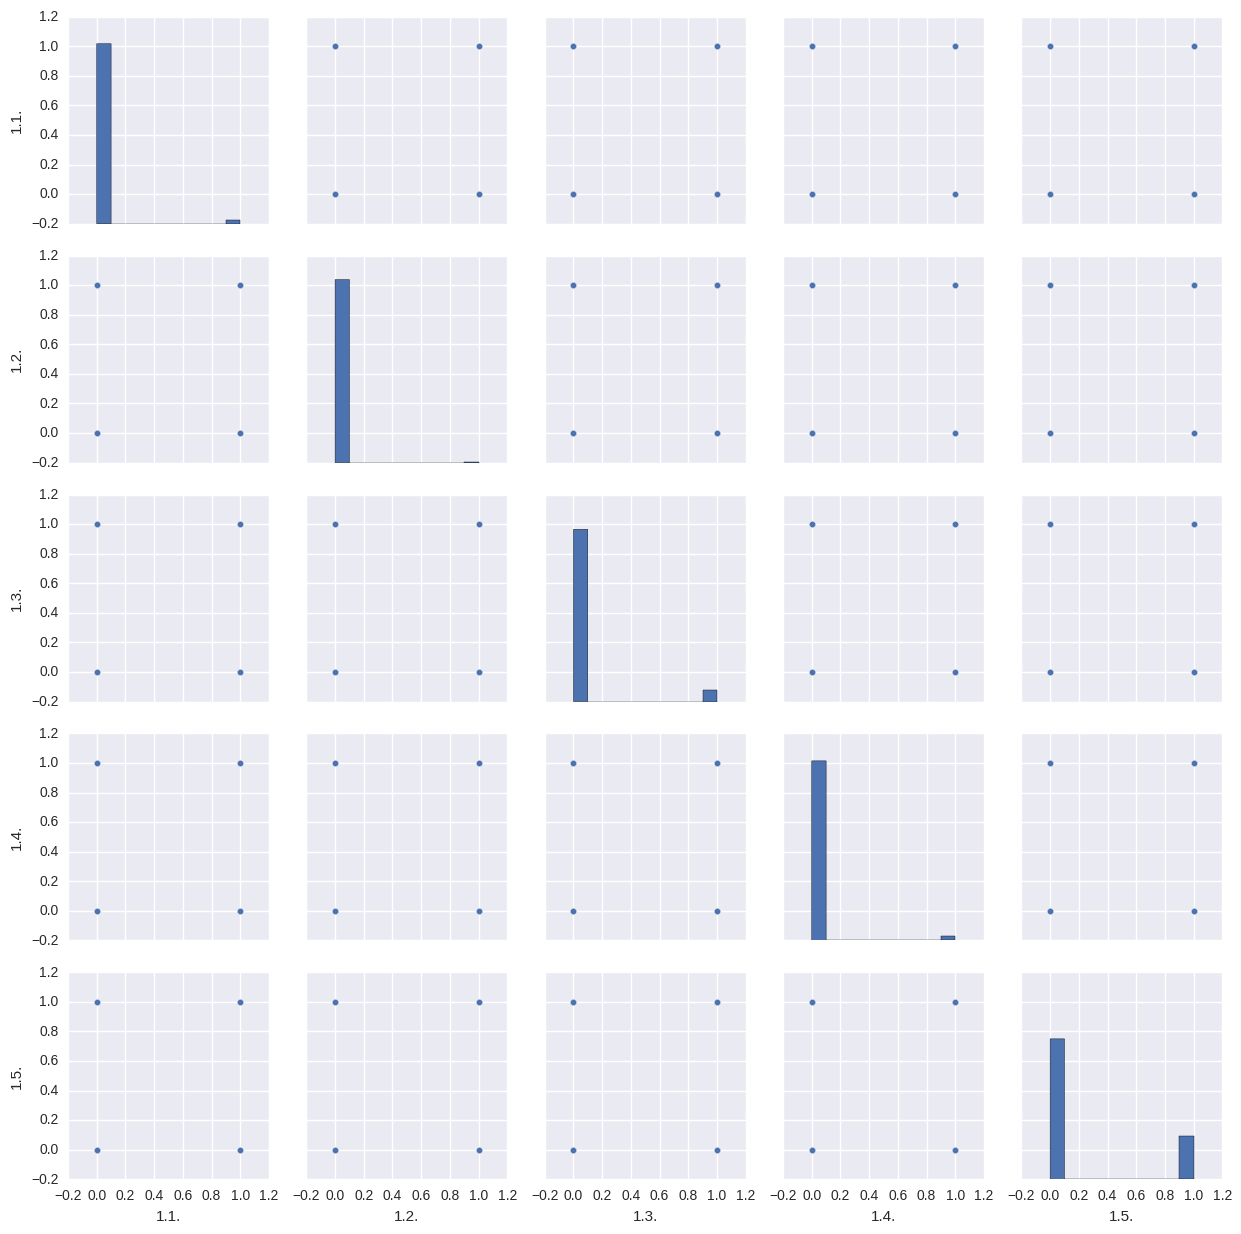

In [12]:
%%time
%config InlineBackend.figure_format = 'png' 
sns.pairplot(train[train.columns[1:6]])# Увеличев размер списка колонок можно понять что нет прямой зависимости фичей 
#друг от друга (на каждом графике 4 точки, значит возможен любой исход)

In [13]:
#Отсюда видно что нет пар когда X3=0 а Y3=1. Тогда предскажем сначала X3 и потом будем подставлять Y3
train[(train['X3']==0)&(train['Y3']==0)]

,report_dt,1.1.,1.2.,1.3.,1.4.,1.5.,1.6.,1.7.,1.8.,1.9.,1.10.,1.11.,1.12.,1.13.,1.14.,1.15.,1.16.,1.17.,1.18.,1.19.,2.1.,2.2.,2.3.,2.4.,2.5.,2.6.,2.7.,2.8.,2.9.,2.10.,2.11.,2.12.,2.13.,2.14.,2.15.,2.16.,3.1.,3.2.,3.3.,3.4.,3.5.,3.6.,3.7.,3.8.,3.9.,3.10.,3.11.,3.12.,3.13.,3.14.,3.15.,X3,Y3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-6IW9T,31.07.2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-12667,31.01.2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-88MWJ,31.05.2015,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-7TKF7,30.06.2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-563FI7,31.07.2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-6B0W56,30.09.2015,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-62178Y,30.06.2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-94O8,31.01.2012,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-48252I,31.05.2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train1 = train.iloc[:,1:-2]
y_train1 = train['X3']

#### Сделаем бейзлан по которому будем улучшать результат. В качестве метрики я выбрал auc и logloss. logloss потому что он сильно штрафует модель если она уверена в неправильном ответе, а аук потому что его проще объяснить бизнесу. Так же, если бы я больше знал о данных(что это такое) возможно стоило бы еще рассмотеть F1_score так как пропорция точности и охвата могла бы быть очень важной, а особенно точности

#### В качестве бейзлайна будем использовать xgboost с кроссвалидацией но с дефолтными параметрами

In [18]:

#baseline that gives 0.644 logloss local
#baseline that gives local 0.922978auc
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train_b = X_train1
target_b = y_train1

from xgboost.sklearn import XGBClassifier
predictors = [x for x in X_train1.columns]
xgb1 = XGBClassifier()
#  learning_rate =0.02,
#  n_estimators=10000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)


# params = {
#          "objective": "binary:logistic", 
#          'max_depth': 4,
#           'eta': 0.02, 
#           'subsample': 0.55, 
#           'colsample_bytree': 0.56,  
#           'eval_metric': 'auc',
#         'lambda':3.3000000000000003,
#         'gamma':4.7,
#         'min_child_weight':8.0,
#         'silent':1,
#         'alpha':0.9}


alg=xgb1
dtrain = X_train1
useTrainCV=True
cv_folds=5
early_stopping_rounds=500
if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train1, label=y_train1)
    cvresult = xgb.cv(params, xgtrain, num_boost_round=100000, nfold=cv_folds,
    metrics='auc', early_stopping_rounds=early_stopping_rounds, 
                      stratified=True,maximize=True)
    alg.set_params(n_estimators=cvresult.shape[0])

/opt/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Первый результат мы получили. Теперь найдем оптимальные гиперпараметры. Оптимизировать будем по логлоссу, что бы регулировать сильные ошибки. А для оптимизации используем hyperopt с логирование результатов

In [19]:
import logging
import time
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
k=0
ts = int(time.time()*1000000) 
log_name = 'xgboost_hyperopt_log_'+ str(ts) 
log_path = '/home/scripts/VErshov/cib/xgboost_hyperopt_log_'+ str(ts) 
def remove_log_and_create_new(log_path, log_name): 
    lgr = logging.getLogger(log_name) 
    lgr.setLevel(logging.DEBUG) 
    fh = logging.FileHandler(log_path) 
    fh.setLevel(logging.DEBUG) 
    lgr.addHandler(fh) 
    frmt = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s') 
    fh.setFormatter(frmt) 
    return lgr; 

def score(params): 
    seed = int(np.random.rand()*100000) 
    params['max_depth'] = int(params['max_depth'])
    lgr.info('\n')
    lgr.info("Training with params : ") 
    lgr.info(params) 
    cv_res = xgb.cv(params, dtrain, early_stopping_rounds=200, maximize=False, 
    num_boost_round=100000, nfold=5, seed = seed, stratified=True
    ) 
    score = cv_res['test-logloss-mean'].min() 
    lgr.info("Score = %f" % score) 
    lgr.info('best rounds = %i' % cv_res[cv_res['test-logloss-mean'] == cv_res['test-logloss-mean'].min()].index[0]) 
    #print(cv_res)
    global k
    k+=1
#     print(k)
    return {'loss': -score, 'status': STATUS_OK} 

dtrain = xgb.DMatrix(X_train1, label=y_train1) 
trials = Trials() 
lgr = remove_log_and_create_new(log_path, log_name) 


space = { 
        'eta' : hp.quniform('eta', 0.001, 0.01, 0.001), 
        'max_depth' : hp.quniform('max_depth', 1, 20, 1), 
        'min_child_weight' : hp.quniform('min_child_weight', 1, 30, 1), 
        'subsample' : hp.quniform('subsample', 0.5, 1, 0.05), 
        'gamma' : hp.quniform('gamma', 0.1, 10, 0.1), 
        'alpha': hp.quniform('alpha', 0.01, 10, 0.1), 
        'lambda': hp.quniform('lambda', 0.01, 10, 0.1), 
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01), 
        'eval_metric': 'logloss', 
        'booster': 'gbtree',  
        'silent' : 1,
        
        } 


best = fmin(fn = score, 
space=space, 
algo=tpe.suggest, 
trials=trials, 
max_evals=100) 
lgr.info(best)

#### Получив оптимальные результаты гиперпараметров будем использовать их({', 'subsample': 0.55, 'max_depth': 4, 'colsample_bytree': 0.56, 'eval_metric': 'logloss', 'eta': 0.01, 'booster': 'gbtree', 'alpha': 0.9, 'silent': 1, 'min_child_weight': 8.0, 'gamma': 4.7, 'lambda': 3.3000000000000003})

In [21]:
def cv_train(X_train,y_train):
    params = {
             "objective": "binary:logistic", 
             'max_depth': 4,
              'eta': 0.01, 
              'subsample': 0.55, 
              'colsample_bytree': 0.56,  
              'eval_metric': 'auc',
            'lambda':3.3000000000000003,
            'gamma':4.7,
            'min_child_weight':8.0,
            'silent':1,
            'alpha':0.9}

    dtrain = xgb.DMatrix(X_train, label=y_train)
    seed = 2017

    cv_res = xgb.cv(params, dtrain, early_stopping_rounds=500, maximize=True, 
        num_boost_round=100000, nfold=5, seed = seed,stratified=True
        ) 
    score = cv_res['test-auc-mean'].max() 
    print("Score = %f" % score) 
    print('best rounds = %i' % cv_res[cv_res['test-auc-mean'] == cv_res['test-auc-mean'].max()].index[0]) 
    print(cv_res)
    return (cv_res.shape[0]-1)

In [22]:
def train_model(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
             "objective": "binary:logistic", 
             'max_depth': 4,
              'eta': 0.01, 
              'subsample': 0.55, 
              'colsample_bytree': 0.56,  
              'eval_metric': 'auc',
            'lambda':3.3000000000000003,
            'gamma':4.7,
            'min_child_weight':8.0,
            'silent':1,
            'alpha':0.9}
    clf = xgb.train(params,dtrain,num_boost_round=cv_train(X_train,y_train),verbose_eval=10)
    return(clf)

### Обучение и предсказание модели

In [23]:
dtestX3 = xgb.DMatrix(testX3)
predsX3= train_model(X_train1,y_train1).predict(dtestX3)

Score = 0.923300
best rounds = 1703
      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.720790      0.018638        0.721717       0.007782
1          0.853341      0.055724        0.855745       0.038665
2          0.865940      0.042348        0.866841       0.025633
3          0.868842      0.041340        0.869157       0.026740
4          0.870170      0.040140        0.872623       0.023821
5          0.870733      0.039796        0.872965       0.024035
6          0.870812      0.039451        0.874955       0.024486
7          0.885869      0.022911        0.887527       0.004833
8          0.885979      0.022983        0.887572       0.004852
9          0.886089      0.022845        0.887702       0.004853
10         0.886002      0.022935        0.887637       0.004847
11         0.886426      0.022692        0.887958       0.004820
12         0.886349      0.022720        0.887910       0.004821
13         0.886275      0.022791        0.887871     

In [24]:
res = pd.DataFrame(predsX3)

res = res.rename(columns={0:'X3'})

res['X3']=res['X3'].apply(lambda x: int(round(x,0)))

testX3=testX3.reset_index()

testY3 = pd.concat([testX3,res],axis=1)

testY3=testY3.set_index('ID')

#### Мы предсказали X3 теперь остается Y3. Есть два варианта либо мы просто берем X3 как параметрдля второй модели (тут минусы в том что X3 может являться очень сильным параметром для Y3 и получится  так называемое 'заглядывание в будующее') либо мы можем убрать из обучающей выборке все X3 = 0, обучиться на тех где X3 = 1 и предсказать Y3. Для всего у чего не будет предсказание(то есть X3 = 0 запишим автоматически Y3 =0). Попробовав оба подхода я остановился на первом, так как он был бы более объективен и не связан со спицификой данных.

In [25]:
testY3.head()

,1.1.,1.2.,1.3.,1.4.,1.5.,1.6.,1.7.,1.8.,1.9.,1.10.,1.11.,1.12.,1.13.,1.14.,1.15.,1.16.,1.17.,1.18.,1.19.,2.1.,2.2.,2.3.,2.4.,2.5.,2.6.,2.7.,2.8.,2.9.,2.10.,2.11.,2.12.,2.13.,2.14.,2.15.,2.16.,3.1.,3.2.,3.3.,3.4.,3.5.,3.6.,3.7.,3.8.,3.9.,3.10.,3.11.,3.12.,3.13.,3.14.,3.15.,X3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-15JF8Z,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-2712QP,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-121YJOD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-165460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-661IF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
X_train2 = train.iloc[:,1:-1]
y_train2 = train['Y3']

### Обучение и предсказание модели

In [27]:
dtestY3 = xgb.DMatrix(testY3)
predsY3= train_model(X_train2,y_train2).predict(dtestY3)

Score = 0.998779
best rounds = 2002
      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.736930      0.132606        0.736393       0.133527
1          0.945743      0.102716        0.951775       0.090453
2          0.960626      0.074535        0.966257       0.062757
3          0.996850      0.001914        0.997075       0.001200
4          0.996439      0.002395        0.996675       0.001494
5          0.996655      0.002304        0.996980       0.001414
6          0.996729      0.002381        0.997103       0.001385
7          0.997444      0.001358        0.997666       0.000831
8          0.997145      0.001579        0.997499       0.000815
9          0.997592      0.000955        0.997827       0.000467
10         0.997595      0.001156        0.997872       0.000626
11         0.997523      0.001431        0.997843       0.000775
12         0.997712      0.001167        0.997966       0.000760
13         0.997630      0.001320        0.997907     

In [28]:
res2 = pd.DataFrame(predsY3,columns={'Y3'})

res2['Y3']=res2['Y3'].apply(lambda x: int(round(x,0)))

testY3 = testY3.reset_index()

In [29]:
test_fin = pd.concat([testY3,res2],axis=1)

#### Получили финальный результат где действительно нет пар X3=0 и Y3=0

In [55]:
test_fin[(test_fin['X3']==0)&(test_fin['Y3']==1)].shape

(0, 53)

### Конец

### Далее показана часть когда для второго подхода описанного ниже но он не завершен и если вы поняли о чем я говорил выше, дальше можно не читать

In [32]:
X_train3 = train.iloc[:,1:-1][train.iloc[:,1:-1]['X3']==1]

In [33]:
y_train3 = train.iloc[:,1:][train.iloc[:,1:-1]['X3']==1]['Y3']

In [34]:
y_train3.value_counts()

1    669
0    297
Name: Y3, dtype: int64

In [35]:
X_train3 = X_train3.iloc[:,:-1]

In [36]:
X_train3.head()

,1.1.,1.2.,1.3.,1.4.,1.5.,1.6.,1.7.,1.8.,1.9.,1.10.,1.11.,1.12.,1.13.,1.14.,1.15.,1.16.,1.17.,1.18.,1.19.,2.1.,2.2.,2.3.,2.4.,2.5.,2.6.,2.7.,2.8.,2.9.,2.10.,2.11.,2.12.,2.13.,2.14.,2.15.,2.16.,3.1.,3.2.,3.3.,3.4.,3.5.,3.6.,3.7.,3.8.,3.9.,3.10.,3.11.,3.12.,3.13.,3.14.,3.15.
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-12QNBK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1-17IKV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1-18XTSS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1-184IVW,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1-7141UB,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [37]:
testY31=testY3[testY3['X3']==1]

testY31 = testY31.iloc[:,:-1]

testY31=testY31.set_index('ID')

In [40]:
dtestY31 = xgb.DMatrix(testY31)
predsY31= train_model(X_train3,y_train3).predict(dtestY31)

Score = 0.872500
best rounds = 263
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.828986      0.033680        0.829067       0.008303
1         0.829062      0.033684        0.830760       0.008838
2         0.834639      0.043478        0.834916       0.004800
3         0.836497      0.041849        0.839617       0.006461
4         0.838852      0.045066        0.841280       0.006261
5         0.842584      0.039504        0.852113       0.011921
6         0.845771      0.040769        0.853939       0.011522
7         0.851313      0.034212        0.859260       0.018446
8         0.851400      0.032552        0.860436       0.019796
9         0.850570      0.031473        0.860373       0.018611
10        0.852266      0.033636        0.860686       0.018042
11        0.851037      0.032887        0.860900       0.017896
12        0.850697      0.033102        0.861978       0.018193
13        0.850527      0.033342        0.863558       0.017478
14   

In [41]:
a = train

a['report_dt']=a['report_dt'].apply(lambda x:pd.to_datetime(x))

res3 = pd.DataFrame(predsY31,columns={'Y3'})

res3['Y3']=res3['Y3'].apply(lambda x: int(round(x,0)))

res3['Y3'].value_counts()

testY31.shape

testY31 = testY31.reset_index()

res['X3'].value_counts()